# Plots for the 2MDM analysis

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize

import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

/tmp/ipykernel_916129/216869905.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import glob,imp,os,shutil


#### Create txname/process translator

In [2]:
# processDict = {'TChiWZ' : r'$\tilde{\chi}_1^\pm \, \tilde{\chi}_2^0 \to W^{(*)} Z^{(*)}\, \tilde{\chi}_1^0 \tilde{\chi}_1^0$',
#               'TChiWH' : r'$\tilde{\chi}_1^\pm \, \tilde{\chi}_2^0 \to W h\, \tilde{\chi}_1^0 \tilde{\chi}_1^0$',
#               'TChiWW' : r'$\tilde{\chi}_1^\pm \, \tilde{\chi}_1^\mp \to W W \, \tilde{\chi}_1^0 \tilde{\chi}_1^0$',
#               'TDTM1F,TDTM2F' : r'$\tilde{\chi}_1^\pm \to \pi^\pm \tilde{\chi}_1^0$, DT'}
# def convertLabel(label):
#     newlabel = label[:]
#     #Replace txnames by process
#     for txlabel,proc in processDict.items():
#         newlabel = newlabel.replace(txlabel,proc) 
#     #Remove off-shell Ws and Zs from ATLAS analyses (since they only appear in on-shell cases)
#     if 'ATLAS' in newlabel:
#         newlabel = newlabel.replace('W^{(*)} Z^{(*)}', 'W Z')
#     return newlabel

In [3]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('../../data/2mdm_results/results.pcl')
print(dataDF.columns.values.tolist()) #Print all columns names

['filename', 'mass.9000006', 'mass.9900032', 'mass.9900026', 'width.9000006', 'width.9900026', 'width.9900032', 'extpar.1', 'extpar.2', 'extpar.3', 'extpar.4', 'extpar.5', 'extpar.6', 'extpar.7', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.zp.b,b', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.t-,t+', 'BRs.sd.chi,chi', 'BRs.zp.chi,chi', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'OutputStatus.sigmacut', 'OutputStatus.minmassgap', 'OutputStatus.maxcond', 'OutputStatus.ncpus', 'OutputStatus.model', 'OutputStatus.promptwidth', 'OutputStatus.stablewidth', 'OutputStatus.eraseprompt', 'OutputStatus.checkinput', 'OutputStatus.doinvisible', 'OutputStatus.docompress', 'OutputStatus.computestatistics', 'OutputStat

#### Set r = 0 for points with no results 

In [4]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [5]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0

### Get points excluded:

In [6]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 957
Total excluded (LHC) = 797
Total allowed = 160



### Create analysis label for excluded points

In [7]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

    
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result0.AnalysisID']
    txList = sorted(row['ExptRes.result0.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    label = label.replace('off','') #Group together on and off-shell topologies
    labels.append(label)
excluded['label'] = labels


In [8]:
nexcluded = [[len(excluded[excluded['label'] == label]),label] for label in excluded['label'].unique()]
nexcluded = sorted(nexcluded,reverse=True)
nexcluded = np.array(nexcluded)
for label in nexcluded[:,1]:
    print(label+': %i'%len(excluded[excluded['label'] == label]))

ATLAS-EXOT-2019-03 (TRV1qq): 590
CMS-EXO-19-012 (TRV1qq): 131
CMS-PAS-EXO-20-008 (TRV1bb): 76


### Define colors and plotting order

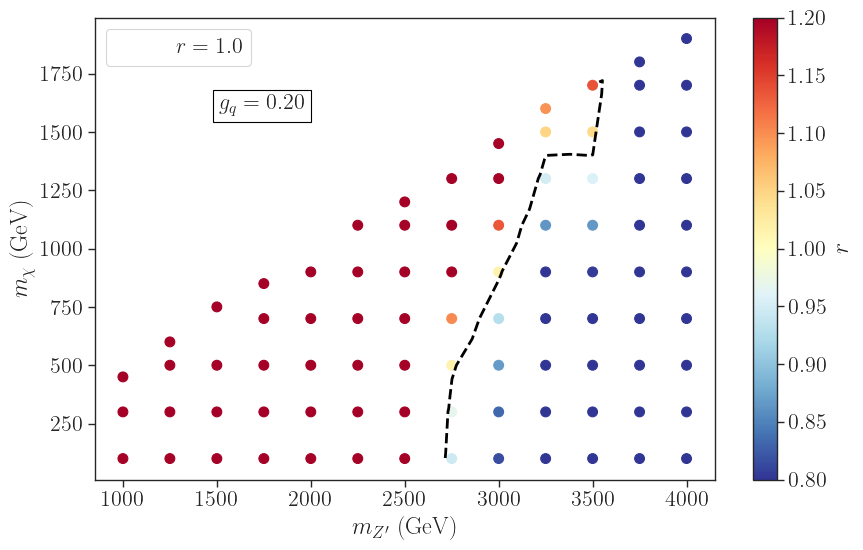

In [9]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(10,6))
# Select points 
gqv = 0.2
x = dataDF['mass.9900032'][dataDF['extpar.2']==gqv]
y = dataDF['mass.9000006'][dataDF['extpar.2']==gqv]
c = dataDF['ExptRes.result0.r'][dataDF['extpar.2']==gqv]
# x = x[c.argsort()]
# y = y[c.argsort()]
# c = c[c.argsort()]

# contour plot
rData = dataDF['ExptRes.result0.r'][(dataDF['extpar.2']==gqv)]
pts = np.array([x for x in product(np.linspace(900.,4100.,300),np.linspace(0.,1800.,300))])
rPts = griddata(list(zip(x,y)),rData,pts)
pts = pts[~np.isnan(rPts)]
rPts = rPts[~np.isnan(rPts)]

cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0],linewidths=2,linestyles='--',colors='black')
cs.collections[0].set_label(r'$r = 1.0$')

plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.8,vmax=1.2)
# # plt.plot([x.min(),x.max()],[x.min(),x.max()],'--')
plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.text(0.2,0.8,r"$g_{q} = %1.2f$" %gqv,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)

plt.legend()
plt.show()

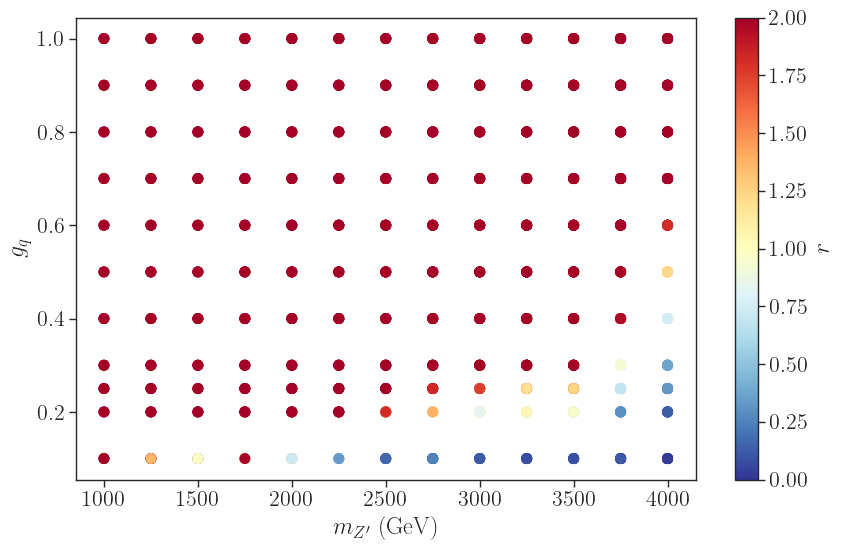

In [10]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(10,6))

x = dataDF['mass.9900032']
y = dataDF['extpar.2']
c = dataDF['ExptRes.result0.r']
x = x[c.argsort()]
y = y[c.argsort()]
c = c[c.argsort()]

plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0,vmax=2)

# # contour plot
# rData = dataDF['ExptRes.result0.r']
# pts = np.array([x for x in product(np.linspace(900.,4100.,300),np.linspace(0.,1800.,300))])
# rPts = griddata(list(zip(x,y)),rData,pts)
# pts = pts[~np.isnan(rPts)]
# rPts = rPts[~np.isnan(rPts)]

# cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0],linewidths=2,linestyles='--',colors='black')
# cs.collections[0].set_label(r'$r = 1.0$')

# # plt.plot([x.min(),x.max()],[x.min(),x.max()],'--')
plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$g_{q}$')

plt.show()

### Z prime Branching Ratio

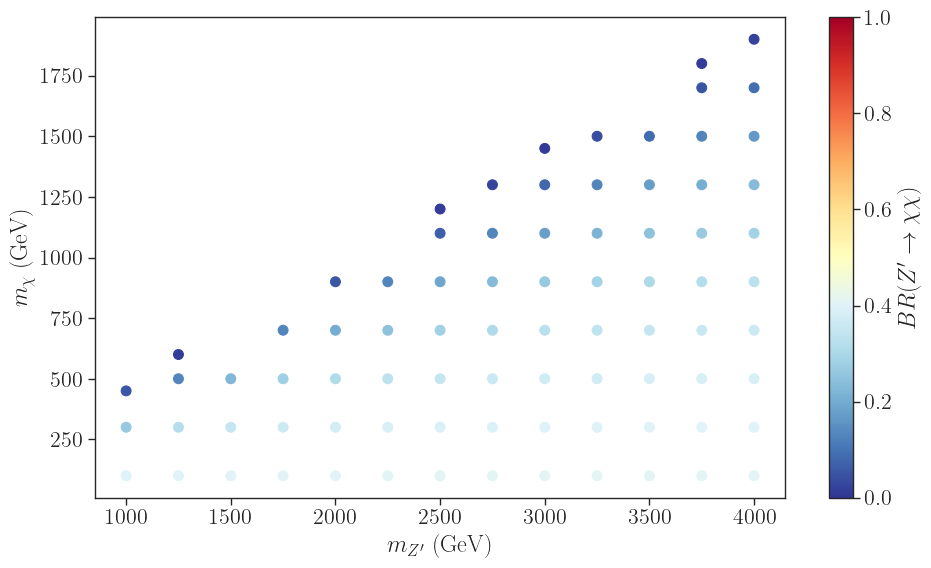

In [11]:
deleteCurves = ['CMS-PAS-EXO-20-008']
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

gqv = 0.2

plt.figure(figsize=(10,6))


cm = plt.cm.get_cmap('RdYlBu_r')
x = dataDF['mass.9900032'][dataDF['extpar.2']==gqv]
y = dataDF['mass.9000006'][dataDF['extpar.2']==gqv]
c = dataDF['BRs.zp.chi,chi'][dataDF['extpar.2']==gqv]


plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0, vmax=1.0)
# plt.plot([x.min(),x.max()],[x.min(),x.max()],'--')
plt.colorbar(label=r'$BR(Z^{\prime} \to \chi \chi)$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.tight_layout()
plt.show()

### Exclusion curve for all

In [12]:
a = []
cols = [c for c in dataDF.columns if c.endswith('AnalysisID')]
    
for c in cols:
    res = dataDF[c].dropna()
    v = res.unique().tolist()
    for i in v:
        a.append(i)
    

analysis = list(np.unique(a))

In [13]:
gqv = 0.2
data = {}
for ana in analysis:
    data[ana] = {'r': [], 'mchi': [], 'mzp': [], 'r_exp': []}
    
for ana in analysis:
    for c in cols:
        p = dataDF.columns.get_loc(c)
        r = dataDF[dataDF.columns[p+5]][(dataDF[c] == ana)&(dataDF['extpar.2']==gqv)].tolist()
        rexp = dataDF[dataDF.columns[p+6]][(dataDF[c] == ana)&(dataDF['extpar.2']==gqv)].tolist()
        m1 = dataDF[(dataDF[c] == ana)&(dataDF['extpar.2']==gqv)]['mass.9000006'].tolist()
        m2 = dataDF[(dataDF[c] == ana)&(dataDF['extpar.2']==gqv)]['mass.9900032'].tolist()
        
        for i, m in enumerate(m1):
            data[ana]['mchi'].append(m)
            data[ana]['mzp'].append(m2[i])
            data[ana]['r'].append(r[i])
            data[ana]['r_exp'].append(rexp[i])
        


In [14]:
colors=['red', 'blue', 'green', 'yellow']

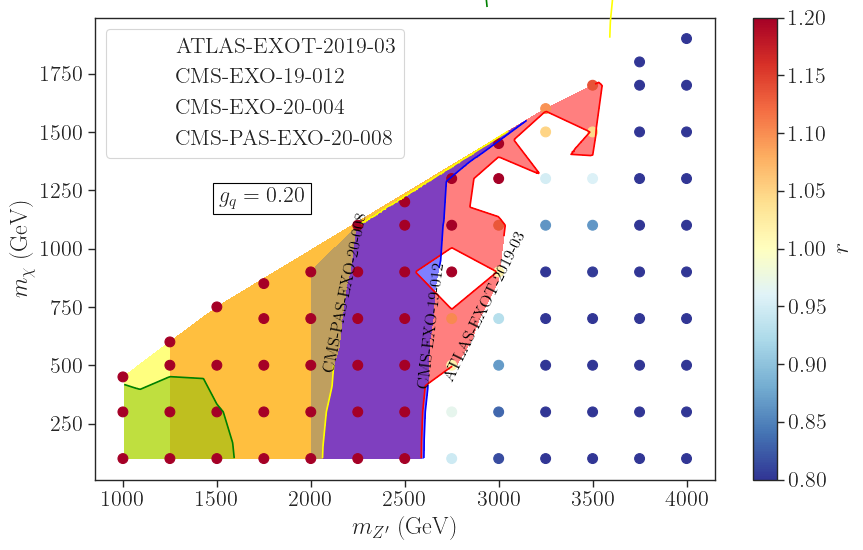

In [15]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(10,6))

# Select points 
# gqv = 0.25
x = dataDF['mass.9900032'][dataDF['extpar.2']==gqv]
y = dataDF['mass.9000006'][dataDF['extpar.2']==gqv]
c = dataDF['ExptRes.result0.r'][dataDF['extpar.2']==gqv]

# ignore = ['ATLAS-EXOT-2019-03']
# Contour plots
for i, ana in enumerate(analysis):
#     if any(val in ana for val in ignore): continue
    rData = data[ana]['r']
    pts = np.array([y for y in product(np.linspace(900.,4100.,300),np.linspace(0.,1800.,300))])
    rPts = griddata(list(zip(data[ana]['mzp'],data[ana]['mchi'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colors[i])
    plt.tricontourf(pts[:,0], pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.5, 
                    colors=colors[i])
    plt.clabel(cs, fontsize=12, fmt=ana, inline=True, colors='black')
    cs.collections[0].set_label(ana)


plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.8,vmax=1.2)
# # plt.plot([x.min(),x.max()],[x.min(),x.max()],'--')
plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.text(0.2,0.6,r"$g_{q} = %1.2f$" %gqv,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)

plt.legend()
plt.show()

### Exclusion curve for CMS-EXO-20-004

In [16]:
cmsCurve_vector = np.genfromtxt('2Dexclusioncontour,vector,Observed.csv', skip_header=12,names=True,delimiter=',')
cmsCurve_axial = np.genfromtxt('2Dexclusioncontour,axial,Observed.csv', skip_header=12,names=True,delimiter=',')

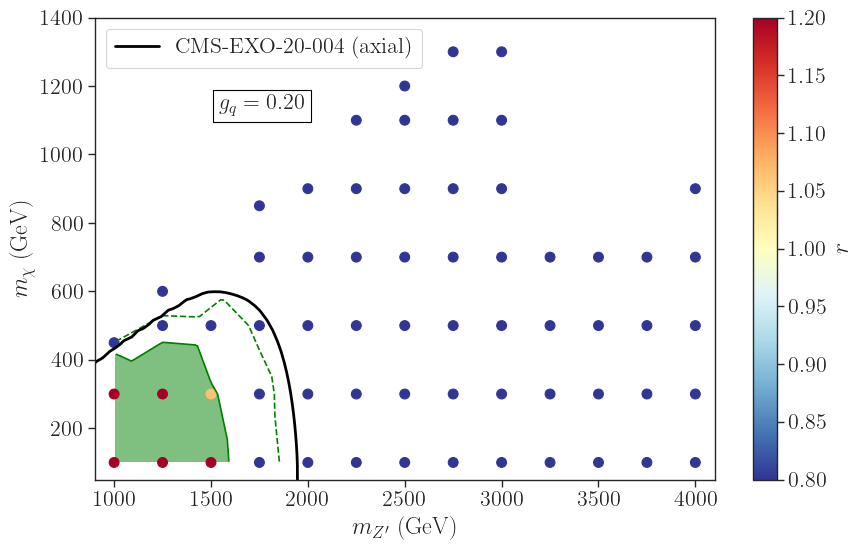

In [17]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(10,6))

# Select points 
# gqv = 0.25
x = data['CMS-EXO-20-004']['mzp']
y = data['CMS-EXO-20-004']['mchi']
c = data['CMS-EXO-20-004']['r']

selectCurve = ['CMS-EXO-20-004']
# Contour plots
for i, ana in enumerate(analysis):
    if any(val not in ana for val in selectCurve): continue
    rData = data[ana]['r']
    pts = np.array([y for y in product(np.linspace(800.,4100.,300),np.linspace(0.,1800.,300))])
    rPts = griddata(list(zip(data[ana]['mzp'],data[ana]['mchi'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colors[i])
    plt.tricontourf(pts[:,0], pts[:,1], rPts, levels=[1.0, max(rPts)], colors=colors[i], alpha=0.5)
    
for i, ana in enumerate(analysis):
    if any(val not in ana for val in selectCurve): continue
    rData = data[ana]['r_exp']
    pts = np.array([y for y in product(np.linspace(800.,4100.,300),np.linspace(0.,1800.,300))])
    rPts = griddata(list(zip(data[ana]['mzp'],data[ana]['mchi'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colors[i], linestyles='dashed')
    
plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.8,vmax=1.2)
# plt.plot(cmsCurve_vector['m_med_GeV'],cmsCurve_vector['m_chi_GeV'],label='CMS-EXO-20-004 (vector)',linewidth=2,color='black')
plt.plot(cmsCurve_axial['m_med_GeV'],cmsCurve_axial['m_chi_GeV'],label='CMS-EXO-20-004 (axial)',linewidth=2,color='black')



plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.text(0.2,0.8,r"$g_{q} = %1.2f$" %gqv,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)

plt.ylim(50, 1400)
plt.xlim(900, 4100)
plt.legend()
plt.show()

### Compare with zp only results

In [18]:
dataDF_zp = pd.read_pickle('../../data/2mdm_results_zp_only/results.pcl')

In [19]:
#Set points without results with r == 0
dataDF_zp.fillna(value={c : 0 for c in dataDF_zp.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF_zp = dataDF_zp.sort_values(by=['ExptRes.result0.r'],ascending=False)

In [20]:
a = []
cols = [c for c in dataDF_zp.columns if c.endswith('AnalysisID')]
    
for c in cols:
    res = dataDF[c].dropna()
    v = res.unique().tolist()
    for i in v:
        a.append(i)
    

analysis_zp = list(np.unique(a))

In [23]:
gqv = 0.25
data_zp = {}
for ana in analysis_zp:
    data_zp[ana] = {'r': [], 'mchi': [], 'mzp': []}
    
for ana in analysis_zp:
    for c in cols:
        p = dataDF_zp.columns.get_loc(c)
        r = dataDF_zp[dataDF_zp.columns[p+5]][(dataDF_zp[c] == ana)&(dataDF_zp['extpar.2']==gqv)].tolist()
        m1 = dataDF_zp[(dataDF_zp[c] == ana)&(dataDF_zp['extpar.2']==gqv)]['mass.9000006'].tolist()
        m2 = dataDF_zp[(dataDF_zp[c] == ana)&(dataDF_zp['extpar.2']==gqv)]['mass.9900032'].tolist()
        
        for i, m in enumerate(m1):
            data_zp[ana]['mchi'].append(m)
            data_zp[ana]['mzp'].append(m2[i])
            data_zp[ana]['r'].append(r[i])
        


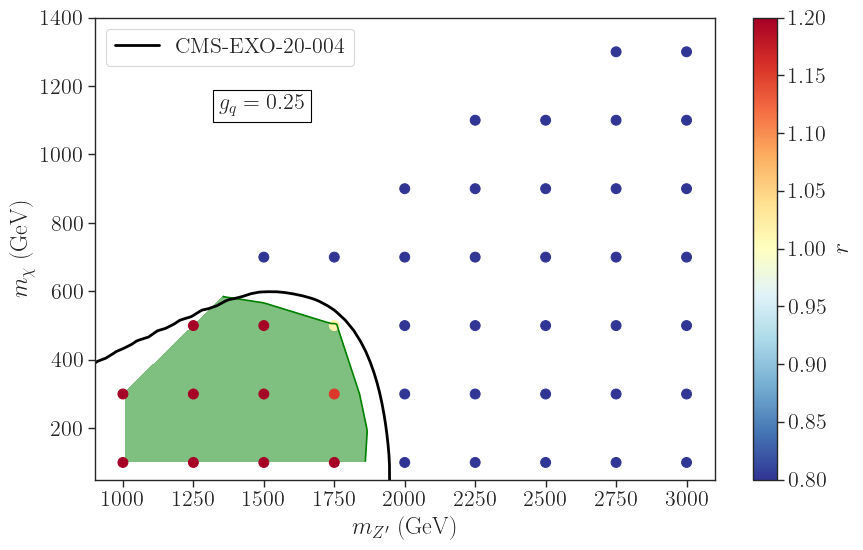

In [24]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(10,6))

# Select points 
# gqv = 0.25
x = data_zp['CMS-EXO-20-004']['mzp']
y = data_zp['CMS-EXO-20-004']['mchi']
c = data_zp['CMS-EXO-20-004']['r']

selectCurve = ['CMS-EXO-20-004']
# Contour plots
for i, ana in enumerate(analysis):
    if any(val not in ana for val in selectCurve): continue
    rData = data_zp[ana]['r']
    pts = np.array([y for y in product(np.linspace(800.,4100.,300),np.linspace(0.,1800.,300))])
    rPts = griddata(list(zip(data_zp[ana]['mzp'],data_zp[ana]['mchi'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colors[i])
    plt.tricontourf(pts[:,0], pts[:,1], rPts, levels=[1.0, max(rPts)], colors=colors[i], alpha=0.5)
    
plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.8,vmax=1.2)
plt.plot(cmsCurve_axial['m_med_GeV'],cmsCurve_axial['m_chi_GeV'],label='CMS-EXO-20-004',linewidth=2,color='black')


plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.text(0.2,0.8,r"$g_{q} = %1.2f$" %gqv,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)


plt.ylim(50, 1400)
plt.xlim(900, 3100)
plt.legend()
plt.show()

In [ ]:
dataCMS = pd.DataFrame.from_dict(data['CMS-EXO-20-004'])
dataCMS = dataCMS[dataCMS['mzp']<=3000]
dataCMS_zp = pd.DataFrame.from_dict(data_zp['CMS-EXO-20-004'])
r_diff = np.abs(dataCMS['r'] - dataCMS_zp['r'])/(dataCMS['r'])

In [ ]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(10,6))

x = dataCMS['mzp']
y = dataCMS['mchi']
c = r_diff

plt.scatter(x,y,c=c,s=50,cmap=cm, norm=LogNorm(vmin=4e-4,vmax=1e-3))
# # plt.plot([x.min(),x.max()],[x.min(),x.max()],'--')
plt.colorbar(label=r'$\frac{|r_{all} - r_{Z^{\prime}}|}{r_{all}}$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.text(0.2,0.8,r"$g_{q} = %1.2f$" %gqv,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)

# plt.legend()
plt.show()